# Example spectral fit:
Fit a parametric spectral model using the debiased Whittle likelihood

Uses a synthetic dataset with known parameters.

In [1]:
# Import libraries (requires jax and optax)
import matplotlib.pyplot as plt
import numpy as onp

from jax import numpy as np
from jax import random as jrandom
import jax.scipy.linalg as jla
import optax

# Local functions
import nonstat_itides_jax as nsjax

In [2]:
# Jax matern code
from jax.scipy.special import gammaln
from jax.scipy.integrate import trapezoid

def calc_dist(x, xpr, eps=1e-14):
    dx2 = np.power(x-xpr, 2.)
    #dx2 = np.where(dx2 < eps, eps, dx2)
    return np.sqrt(dx2)
    
###
# Special functions that are not in 
def gamma(x):
    return np.exp(gammaln(x))

# Modified bessel function of the second kind
#https://github.com/google/jax/issues/9956

def phi(t):
    return np.exp(np.pi / 2 * np.sinh(t))

def dphi(t):
    return np.pi / 2 * np.cosh(t) * np.exp(np.pi / 2 * np.sinh(t))

def bessel_k(nu, z):
    
    z = np.asarray(z)[..., None]
    t = np.linspace(-3, 3, 101)[None, :]
    integrand = 0.5*(0.5*z)**nu*np.exp(-phi(t)-z**2/(4*phi(t)))*phi(t)**(-nu-1)*dphi(t)

    #return np.trapz(integrand, x=t, axis=-1)
    return trapezoid(integrand, x=t, axis=-1)

def matern_general(dx, eta, nu, l):
    
    cff1 = np.sqrt(2*nu)*dx/l
    K = np.power(eta, 2.) * np.power(2., 1-nu) / gamma(nu)
    K *= np.power(cff1, nu)
    K *= bessel_k(nu,cff1)
    #x = x.at[idx].set(y)
    
    idx = 1/dx > 1e12
    return np.where(idx, np.power(eta,2.), K)

    #return K.at[idx].set(np.power(eta, 2.))
    #return K

def matern_general_1d(x, xpr, params):
    eta, nu, l = params
    dx = calc_dist(x, xpr)
    return matern_general(dx, eta, nu, l)

In [26]:
def my_itide_D2_meso_gammaexp(x, xpr, params, 
                     lt = 0.5, l_m=3):

    eta_m, gam_m, eta2, d2, gam1 = params
    
    C = eta_m**2 * nsjax.gamma_exp(x, xpr, gam_m, l_m)
    C += nsjax.oscillate_1d_gammaexp(x, xpr, (eta2, d2, lt, gam1))

    return C

def my_itide_D2_meso_matern(x, xpr, params, 
                     lt = 0.5, l_m=3):

    eta_m, nu_m, eta2, d2, gam1 = params
    
    C = matern_general_1d(x, xpr, (eta_m, nu_m, l_m))
    C += nsjax.oscillate_1d_gammaexp(x, xpr, (eta2, d2, lt, gam1))

    return C

In [75]:
###
# Name of the parametric covariance function
#covfunc=nsjax.itide_D2_meso_gammaexp
#covfunc=my_itide_D2_meso_gammaexp
covfunc=my_itide_D2_meso_matern

# True values of the covariance model parameters
eta_d2 = 0.01
tau_d2 = 5.0
gam_d2 = 1.5

eta_m = 0.01
tau_m = 3.
gam_m = 3.0

cov_kwargs = {'l_m':3.}


# Frequency bands for fitting
fmin = 1.0 #0.7
fmax = 30 #

# Parameters for the time domain
dt = 1/48.
ndays = 60
###
#covparams = (eta_m, tau_m, gam_m, eta_d2, tau_d2, gam_d2)
covparams = (eta_m, gam_m, eta_d2, tau_d2, gam_d2)

# Time in days
X = np.arange(0, ndays, dt)
N = X.shape[0]

CPU times: user 5.18 s, sys: 9.01 s, total: 14.2 s
Wall time: 7.85 s


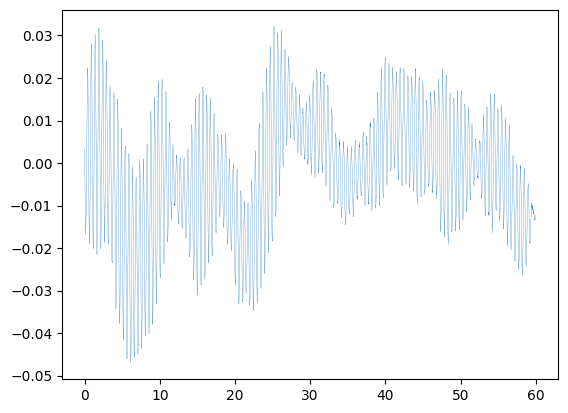

In [76]:
%%time
# Create a synthetic sample by drawing from a multivariate normal
K = covfunc(X[:,None], X[:,None].T, covparams)
L =  jla.cholesky(K+1e-7*np.eye(N), lower=True)

key = jrandom.PRNGKey(43)
myrand = jrandom.normal(key, shape=(N,)) 
        
y = L.dot(myrand) 
plt.plot(X,y, lw=0.2)

Text(0.5, 0, 'f [cpd]')

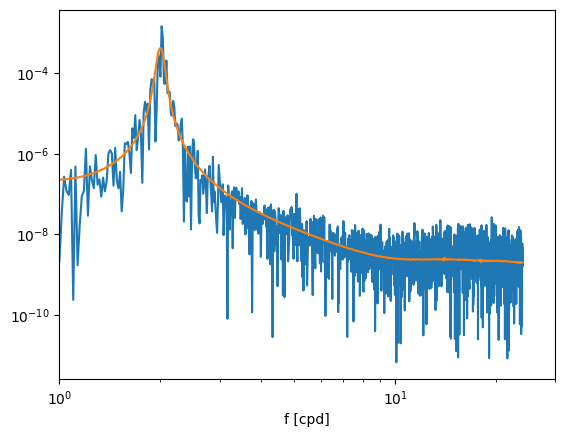

In [77]:
# Plot the periodogram of the time-series data and the parametric spectral profile
acf = covfunc(X, X[0], covparams, **cov_kwargs)
f, I = nsjax.periodogram(y, dt)
# bochner function does the discrete ifft
f_S, S = nsjax.bochner(acf, delta=dt)

plt.figure()
plt.loglog(f, I)
plt.loglog(f_S,S)
plt.xlim(fmin, fmax)
plt.xlabel('f [cpd]')

In [84]:
# Use a log transformer to put constraints on the parameters

#covparams_guess = (0.02, 4, 1.0, 0.005, 10, 1.8)
covparams_guess = (0.01, 2.5, 0.005, 10, 1.8)

params, loss_val = nsjax.estimate_jax(onp.array(y), onp.array(X), 
                      covfunc, covparams_guess,
                      fmin, fmax,
                      maxiter=1000,
                     opt= optax.adabelief(learning_rate=1e-2),
                     transformer=nsjax.LogTransformer,
                     verbose=True)

print(72*'#')
print('Truth: ', covparams)
print('Estimated: ',params)

step 0, loss: -44017.80078125
[1.0100499e-02 2.5251253e+00 5.0502494e-03 9.9004984e+00 1.7820897e+00]
step 25, loss: -48288.2109375
[1.35568185e-02 2.65301228e+00 6.86131045e-03 6.91949940e+00
 1.26955342e+00]
step 50, loss: -48375.50390625
[0.01451711 2.7475657  0.00743336 6.217994   1.1825628 ]
step 74, loss: -48407.48046875
########################################################################
Truth:  (0.01, 3.0, 0.01, 5.0, 1.5)
Estimated:  [0.01431922 2.793641   0.00739143 6.324642   1.256082  ]


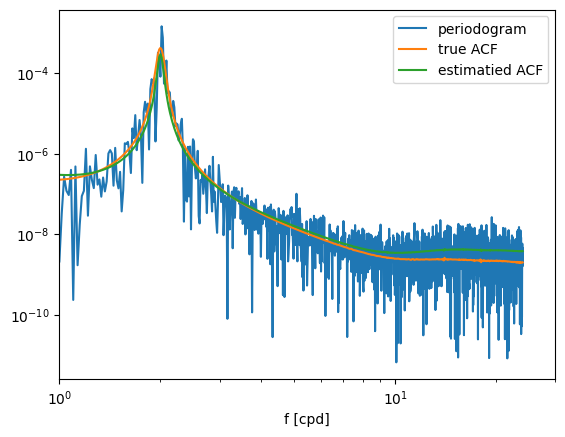

In [85]:
f, I = nsjax.periodogram(y, dt)
acf = covfunc(X, X[0], covparams, **cov_kwargs)
f_S, S = nsjax.bochner(acf, delta=dt)
acf = covfunc(X, X[0], params, **cov_kwargs)
_, S_est = nsjax.bochner(acf, delta=dt)

plt.figure()
plt.loglog(f, I)
plt.loglog(f_S,S)
plt.loglog(f_S,S_est)

plt.xlim(fmin, fmax)
plt.xlabel('f [cpd]')
plt.legend(('periodogram','true ACF','estimatied ACF'))